##### Copyright 2018 The TensorFlow Authors.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
import pathlib
data_dir = pathlib.Path("data-train")

After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.jpeg'))) + len(list(data_dir.glob('*/*.png')))
print(image_count)

3014


Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 256
img_width = 256

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    crop_to_aspect_ratio=True,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3014 files belonging to 12 classes.
Using 2412 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    crop_to_aspect_ratio=True,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3014 files belonging to 12 classes.
Using 602 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [8]:
class_names = train_ds.class_names
print(class_names)

['chihuahua', 'chow', 'corgi', 'dingo', 'french_bulldog', 'golden', 'husky', 'japanese_spaniel', 'pitbull', 'poodle', 'pug', 'samoyed']


## Visualize the data

Here are the first 9 images from the training dataset.

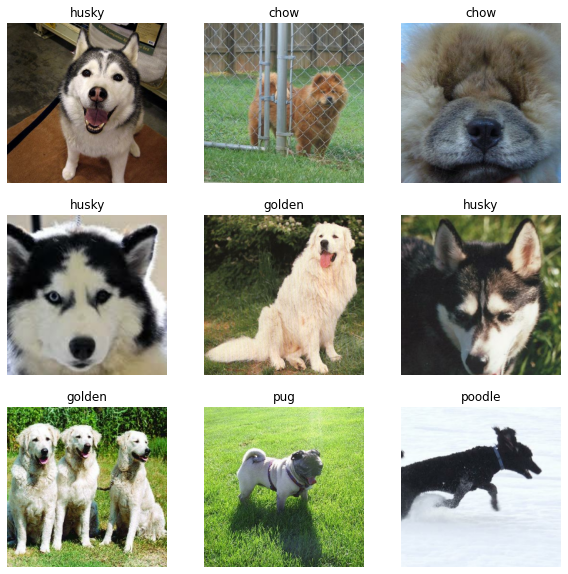

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will train a model using these datasets by passing them to `model.fit` in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [10]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import Input
from tensorflow.keras.applications import xception
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten,BatchNormalization,Activation

In [11]:
base_model = xception.Xception(weights='imagenet', include_top=False, input_shape=(256,256,3)) 
# display(base_model.summary())

# train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
base_model.trainable = False

inputs = Input(shape=(256, 256, 3))
x = xception.preprocess_input(inputs) ##  tf.keras.applications.xception.preprocess_input

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here by passing `training=False`.
x = base_model(x, training=False)

x = GlobalAveragePooling2D()(x)

#     adding extra dense layer
#     x = Dense(1024, activation='relu')(x)
#     x = Dropout(.7)(x)
#     x = Dense(512, activation='relu')(x)

x = Dropout(.5)(x)
outputs = Dense(12, activation='softmax')(x)
model = Model(inputs, outputs)

display(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

None

In [12]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [13]:
optimizer = Adam(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'], optimizer=optimizer)

In [14]:
model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(1024, activation='relu'),
    layers.Dropout(0.7),
    layers.Conv2D(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(120, activation='softmax'),
    layers.Dense(12)
])

NameError: name 'data_augmentation' is not defined

## Compile and train the model

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [18]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


C:\Users\mvdon\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


 8/76 [==>...........................] - ETA: 3:18 - loss: 1.8182 - accuracy: 0.5078

KeyboardInterrupt: 

## Visualize training results

After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned. 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'history' is not defined

In [ ]:
model.save("doggy_v4.h5")

/opt/anaconda3/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## Predict on new data

In [ ]:
new_model = tf.keras.models.load_model('doggy_v4.h5')

In [ ]:
from heapq import nlargest
import base64

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and Dropout layers are inactive at inference time.

In [ ]:
imgUrl = "https://upload.wikimedia.org/wikipedia/commons/e/ee/Red_eyed_tree_frog.jpg"
path = tf.keras.utils.get_file('', origin=imgUrl)

img = keras.preprocessing.image.load_img(
    path, target_size=(256, 256)
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = new_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
# print(str(score))
largestRs = nlargest(3, range(len(predictions.reshape(12))), predictions.reshape(12).take)
print("Detect result: {}".format(class_names[largestRs[0]])
)

434176/425789 [==============================] - 0s 1us/step
Detect result: dingo
